<a href="https://colab.research.google.com/github/nishithewel/ID5059GroupProject/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/nishithewel/ID5059GroupProject.git

Cloning into 'ID5059GroupProject'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 169 (delta 89), reused 72 (delta 32), pack-reused 0
Receiving objects: 100% (169/169), 12.86 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [ ]:
! git pull

### Downloading the Data from kaggle.

In [ ]:

!pip install -q kaggle
from google.colab import files
files.upload()
!rm -rf sample_data
!mkdir  -p /root/.kaggle/
!mv kaggle.json  /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls -lart /root/.kaggle/
!kaggle competitions download -c 'ieee-fraud-detection'
!mkdir data
!mv ieee-fraud-detection.zip data/
!unzip data/ieee-fraud-detection.zip -d data/

KeyboardInterrupt: ignored

## Introduction to the Dataset


### Team Members
- Nishithe Welandawe - naw4
- Joseph Edwards - jde1
- Anli Hu
- 
-


### Installs and Imports

In [ ]:
! pip install imblearn 

In [ ]:
import os
os.chdir('/content/ID5059GroupProject')
import numpy as np 
import pandas as pd
from google.colab import drive
from imblearn import over_sampling
from utils.preprocess import preprocess
from utils.reduce_memory import reduce_mem_usage
# os.chdir('/content/ID5059GroupProject')

from utils.model_stack import stack_models



### Loading the dataset
- Upload the unzipped datasets to your google drive
- Update root_dir with the folder containing the datasets

In [ ]:
### You need to change these codes to load your dataset
#if youre files are stored in google drive do this
DRIVE_STORE = True
if DRIVE_STORE == True:
  drive.mount('/content/drive') 
  root_dir = '/content/drive/MyDrive/Python/ID5059-GroupProject/ieee-fraud-detection/' #for nish
  
else:
  root_dir = '/content/ID5059GroupProject/data/'
# os.chdir(root_dir)

test_iden = pd.read_csv(root_dir + 'test_identity.csv',)
test_tran = pd.read_csv(root_dir +'test_transaction.csv',)
train_iden = pd.read_csv(root_dir +'train_identity.csv',)
train_tran = pd.read_csv(root_dir +'train_transaction.csv',)


test_tran = reduce_mem_usage(test_tran)
train_tran = reduce_mem_usage(train_tran)  

train = pd.merge(train_tran, train_iden, on = 'TransactionID', how = 'left')
test = pd.merge(test_tran, test_iden, on = 'TransactionID', how = 'left')

# train = reduce_mem_usage(train)  


# #Run this otherwise might cause ram overflows
# v_cols = [col for col in train.columns if 'V' in col]
# # lets ignore the v columns for the time being
# train.drop(v_cols,axis =1, 
#                 inplace = True)


del train_tran, train_iden, test_iden, test_tran


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


test_dataset and train_dataset had a mismatch in the name of id features. In the train_dataset id features were present with the name id_x where x was a value between 01 and 38 whereas in the test_dataset id features were of the form id-x. So, we changed the format of id features in the test_dataset from id-x to id_x.

In [ ]:
test.columns  = [col.replace('-','_') for col in test.columns]
print([col for col in test.columns if col.startswith('id')])

['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


## EDA
We perform basic analysis on the data.
- Visualise predictor distribution.
- Correlation


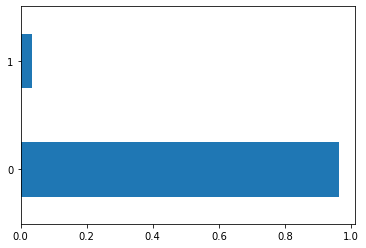

In [ ]:
train['isFraud'].value_counts(
    normalize = True).plot(kind= 'barh')

We find very few instance of Fraud. Consider Class Balancing.

## Feature Preproccessing

Systematically, deal with features by considering the following,
- 'M' columns
- 'D' columns - these are fine all numerical
- 'C' columns - numerical except for 4,6

We deal with categorical variables using dummy vars.

In [ ]:


train = preprocess(train)

test = preprocess(test)

#the M columns look like true or false lets convert them to 1, 0 
m_cols = [col for col in train.columns if col.startswith('M')]
# m_cols.head()


In [ ]:
train[m_cols] = train[m_cols].replace(dict(T=1,F=0))
test[m_cols] = test[m_cols].replace(dict(T=1,F=0))


What features are we dropping and why?

- TransactionID - Only a unique identifier for identity
- Id Columns - All Id columns contain at least 75% NaN values 


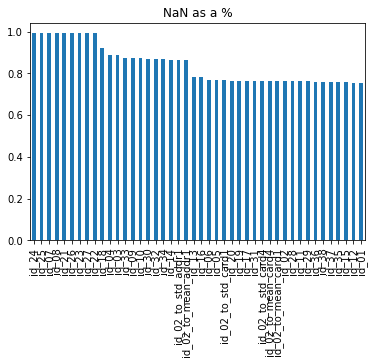

In [ ]:
id_cols = [col for col in train.columns if col.startswith('id')]
df_id = train[id_cols]
# df_id.head()
nulls = df_id.isnull().sum()/len(df_id) #as a percentage
nulls.sort_values(ascending=False).plot.bar(title='NaN as a %')
# train.drop(id_cols, axis = 1,inplace = True)

In [ ]:
#Run this otherwise might cause ram overflows
v_cols = [col for col in train.columns if col.startswith('V')]
# # lets ignore the v columns for the time being
train.drop(v_cols,axis =1, inplace = True)
train.drop(id_cols, axis = 1,inplace = True)
train.drop('TransactionID',axis = 1,inplace = True)

In [ ]:
categorical_features = list(set(train.columns) - set(train._get_numeric_data().columns))
get_dummy_cols = []
for col in categorical_features:
  print('# of unique cats in',col,' is', len(train[col].unique()) )
  if len(train[col].unique()) < 15:
    get_dummy_cols.append(col)

# of unique cats in card6  is 5
# of unique cats in R_emaildomain  is 61
# of unique cats in R_emaildomain_2  is 10
# of unique cats in DeviceInfo  is 1787
# of unique cats in browser_id_31  is 40
# of unique cats in OS_id_30  is 8
# of unique cats in P_emaildomain_2  is 9
# of unique cats in P_emaildomain  is 60
# of unique cats in M4  is 4
# of unique cats in R_emaildomain_3  is 6
# of unique cats in ProductCD  is 5
# of unique cats in screen_height  is 139
# of unique cats in card4  is 5
# of unique cats in device_version  is 295
# of unique cats in device_name  is 14
# of unique cats in version_id_31  is 41
# of unique cats in screen_width  is 156
# of unique cats in R_emaildomain_1  is 46
# of unique cats in P_emaildomain_3  is 6
# of unique cats in version_id_30  is 44
# of unique cats in P_emaildomain_1  is 45
# of unique cats in DeviceType  is 3


In [ ]:

from sklearn.preprocessing import OneHotEncoder  #the disco import 

for col in get_dummy_cols:
  enc = OneHotEncoder(handle_unknown='ignore',sparse=False) 
  dummy_train = enc.fit_transform(train[col].to_numpy().reshape(-1, 1))
  new_col = [ col+'_' + str(i)  for i in enc.categories_[0].tolist()]


  # for df in [train, test]:
  dummy_test = enc.transform(test[col].to_numpy().reshape(-1, 1))

  dummy_dftest = pd.DataFrame(dummy_test, columns = new_col)
  dummy_dftrain = pd.DataFrame(dummy_train, columns = new_col)

  test = pd.concat([test, dummy_dftest],axis =1)
  train = pd.concat([train, dummy_dftrain],axis =1)


    # df.drop(col,axis =1,inplace=True)
  
train.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'device_name_nan', 'P_emaildomain_3_com', 'P_emaildomain_3_jp',
       'P_emaildomain_3_mx', 'P_emaildomain_3_uk', 'P_emaildomain_3_None',
       'P_emaildomain_3_nan', 'DeviceType_desktop', 'DeviceType_mobile',
       'DeviceType_nan'],
      dtype='object', length=162)

We need to deal with the variables with high number of cats.

In [ ]:
train.drop(get_dummy_cols,axis =1,inplace = True )
test.drop(get_dummy_cols,axis =1,inplace = True )

In [ ]:
large_cats = list(set(train.columns) - set(train._get_numeric_data()))
large_cats

['screen_height',
 'P_emaildomain',
 'version_id_30',
 'R_emaildomain',
 'device_version',
 'P_emaildomain_1',
 'DeviceInfo',
 'version_id_31',
 'screen_width',
 'browser_id_31',
 'R_emaildomain_1']

In [ ]:
for col in large_cats:
  print(col,train[col].unique()[:5])

screen_height [nan '1080' '750' '800' '768']
P_emaildomain [NaN, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com']
Categories (59, object): ['aim.com', 'anonymous.com', 'aol.com', 'att.net', ..., 'yahoo.de',
                          'yahoo.es', 'yahoo.fr', 'ymail.com']
version_id_30 [nan '7.0' '11.1.2' 'OS' '10']
R_emaildomain [NaN, 'gmail.com', 'hotmail.com', 'outlook.com', 'anonymous.com']
Categories (60, object): ['aim.com', 'anonymous.com', 'aol.com', 'att.net', ..., 'yahoo.de',
                          'yahoo.es', 'yahoo.fr', 'ymail.com']
device_version [nan 'NRD90M' None 'MRA58K' 'NPN26.118-22-2']
P_emaildomain_1 [nan 'gmail' 'outlook' 'yahoo' 'mail']
DeviceInfo [nan 'SAMSUNG SM-G892A Build/NRD90M' 'iOS Device' 'Windows' 'MacOS']
version_id_31 [nan 'browser' 'safari' '62.0' '15.0']
screen_width [nan '2220' '1334' '1280' '1366']
browser_id_31 [nan 'samsung' 'mobile' 'chrome' 'edge']
R_emaildomain_1 [nan 'gmail' 'hotmail' 'outlook' 'anonymous']


In [ ]:
def frequency_encoder(x,groupby):
  if x == None:
    return groupby[np.nan]
  else:
    return groupby[x]


  # large_cats
for col in large_cats:
  freq_enc = (train.groupby(col,dropna=False  # to prevent loss of information
                            ).size()) / len(train)
  train[col+'freq'] = train[col].apply(lambda x : frequency_encoder(x,freq_enc))
  # train.drop(col,axis= 1 , inplace = True)
train.drop(large_cats,axis = 1,inplace = True)


### Column Imputation
How are we dealing with NaN/Missing/Infinite Values?



In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 151 entries, isFraud to R_emaildomain_1freq
dtypes: float16(45), float64(102), int16(1), int32(1), int64(1), int8(1)
memory usage: 523.2 MB


In [ ]:
nulls = train.isnull().sum()/len(train)
nulls.sort_values()

isFraud                 0.000000
P_emaildomain_2_None    0.000000
P_emaildomain_2_nan     0.000000
M4_M0                   0.000000
M4_M1                   0.000000
                          ...   
D12                     0.890410
D14                     0.894695
D13                     0.895093
D7                      0.934099
dist2                   0.936284
Length: 151, dtype: float64

In [ ]:
train_na = train.dropna(thresh= 0.8 * len(train),axis = 1)

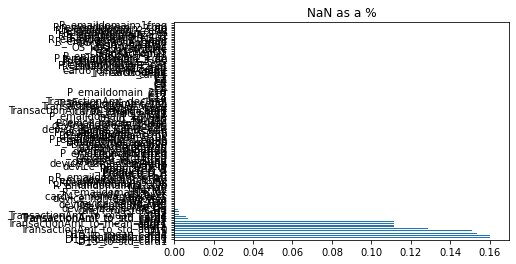

In [ ]:
nulls = train_na.isnull().sum()/len(train_na) #as a percentage
nulls.sort_values(ascending=False).plot.barh(title='NaN as a %')

### Feauture Cleaning
The data contains outliers, which require cleaning.

### Feature engineering (Creation)
Wrapped as Preprocessor function to be implemented after test train split.

### Class Balancing

In [ ]:
train = train._get_numeric_data()
X_train, y_train = train.drop('isFraud',axis = 1), train['isFraud']
# oversample = over_sampling.SMOTE()
#X_train, y_train = oversample.fit_resample(X_train, y_train)

## Model Creation & Fitting


### Individiual models

In [ ]:

# model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
# model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

In [ ]:
#naw4
from sklearn.model_selection import RandomizedSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

# train.drop(['P_emaildomain', 'R_emaildomain'],axis =1 ,inplace = True)
from sklearn.metrics import accuracy_score

import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

clf = RandomizedSearchCV(estimator=xgb_cl,
                         param_distributions=params,
                         n_jobs = -1,
                        #  scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
search = clf.fit(X_train, y_train)

# xgb_cl.fit(X_train, y_train)
preds = xgb_cl.predict(X_train)
accuracy_score(y_train, preds)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: ignored

In [ ]:
clf.get_params()

<bound method BaseEstimator.get_params of RandomizedSearchCV(estimator=XGBClassifier(), n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 6, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   verbose=1)>

In [ ]:
bst.save_model('model_file_name.json')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train, preds,normalize='true')

In [ ]:
#jde1
from sklearn import datasets, svm
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
# train.drop(['P_emaildomain', 'R_emaildomain'],axis =1 ,inplace = True)

percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
high_na = list(missing_value_df.loc[missing_value_df['percent_missing']>0.2]['column_name'])

j_train = train.drop(high_na, axis = 1)
j_train.dropna(inplace=True)

X_train, y_train = j_train.drop('isFraud',axis = 1), j_train['isFraud']

# imp = SimpleImputer(strategy="most_frequent")
# j_train = imp.fit_transform(j_train)
clf = svm.LinearSVC()

feature_map_nystroem = Nystroem(gamma=.2,
                                 random_state=1,
                                 n_components=300)
data_transformed = feature_map_nystroem.fit_transform(X_train)
clf.fit(data_transformed, y_train)
LinearSVC()
preds = clf.predict(data_transformed)
accuracy_score(y_train, preds)

In [ ]:
preds = clf.predict(data_transformed)
accuracy_score(y_train, preds)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train, preds,normalize='true')

In [ ]:
! pip uninstall lightgbm -y

# install lightgbm GPU
! pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"


In [ ]:
#anli
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'device':'gpu',
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 5313,
         }
from sklearn.model_selection import train_test_split
score = 0

feature_importances = pd.DataFrame()
lgb_X_train, lgb_X_valid,lgb_y_train, lgb_y_valid=train_test_split(X_train,y_train,train_size=0.8)
dtrain = lgb.Dataset(lgb_X_train, label=lgb_y_train)
dvalid = lgb.Dataset(lgb_X_valid, label=lgb_y_valid)
clf = lgb.train(params, dtrain, 4000, valid_sets = [dtrain, dvalid])

feature_importances = clf.feature_importance()

y_pred_valid = clf.predict(lgb_X_valid)
score = roc_auc_score(lgb_y_valid, y_pred_valid)

print(f"AUC = {score}")

In [ ]:
#wonchoi

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse

# Create a random forest regressor model with the best hyperparameter fits 
rf_final = RandomForestRegressor(n_estimators = 90, max_depth = 5, n_jobs = -1, oob_score = True, random_state = 30801)
rf_final = rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_train)

# Calculate its rmse to compare with the previous model
res_rmse = mse(y_train, y_pred, squared = True)

# Calculate its oob score
res_oob = rf_final.oob_score_
print('Root mean squared error:', res_rmse,'Out of box score of final model: ', res_oob)

### Model Ensembling

In [ ]:
stack_models(('Nishi', xgb_cl))